<a href="https://colab.research.google.com/github/mgarasz/basic-transaction-fraud-detection/blob/main/transaction_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from google.colab import drive

In [2]:
# Mount Google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Projects/Data/creditcard/'

/content/drive/MyDrive/Projects/Data/creditcard


In [4]:
# Import the Credit Card Fraud Detection dataset
cc_fraud_data = pd.read_csv('/content/drive/MyDrive/Projects/Data/creditcard/creditcard.csv')
cc_fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Define a custom SMOTE class to be used in the pipeline
class SMOTE_Pipeline(SMOTE):
    def fit(self, X, y=None, **fit_params):
        X, y = super().fit_resample(X, y)
        return super().fit(X, y, **fit_params)
    def transform(self, X, y=None, **fit_params):
        return X

In [6]:
# Create copy of data to preserve original state
data = cc_fraud_data.copy()

# Remove missing values
data.dropna(inplace=True)

# Split the target variable into features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
# Define the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns)
    ])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE_Pipeline()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=200))
])

# Define the hyperparameter grid for grid search
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

In [8]:
# Perform grid search with cross-validation; you wanna optimize for precision as false positive predictions can have significant cost, more so than a false negative. 
grid = GridSearchCV(pipe, param_grid, scoring="precision", cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object'))])),
                                       ('sampler', SMOTE_Pipeline()),
                                       ('classifier',
                                        LogisticRegression(max_iter=200,
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='precision', verbose=1)

In [16]:
grid.best_params_, grid.best_score_

({'classifier__C': 0.1, 'classifier__penalty': 'l2'}, 0.8827499436846502)

In [17]:
pipe_tuned = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE_Pipeline()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=200, C=0.1, penalty='l2'))
])

pipe_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object'))])),
                ('sampler', SMOTE_Pipeline()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=200, solver='liblinear'))])

In [18]:
y_pred = pipe_tuned.predict(X_test)

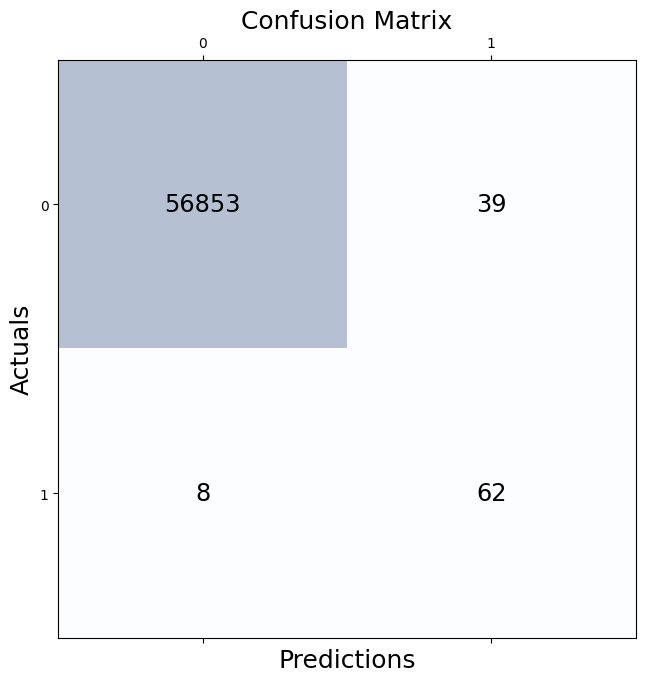

In [19]:
# Print the confusion matrix using Matplotlib
conf_matrix = confusion_matrix(y_pred, y_test)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()